lstm2

과정 요약:<br> 
feature: season, day of week, week number, sales <br> 
feature engineering: normalize+ denormalize

결과요약: seed 7: rmse 96.04 (마지막 

상세과정:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 
이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 LSTM 시도2에서는 제외함

추가의견) 개인적으로 이상점을 제거한 후 normalize를 하면 rmse가 커질 수 밖에 없다고 생각함. 다음시도(lstm3)은 이상점을 제거하지 않고 normalize를 하고, lstm4에서는 이상점을 제거하고 normalize를 하지 않는 것을 시도하겠다.

추가의견2) 처음에는 denormalize과정 없이 rmse를 구했는데, 이것보다는 denormalize를 한 후 rmse를 구하여 모델간 비교를 하는 것이 더 적절한 것 같다. normalize는 어디까지나 변환이니 항상 변환을 할때는 역변환을 하여 원본 데이터 형태m로 생각하는 것이 덜 헷갈리고, 결과값에 대한 더욱 직관적인 이해가 가능할 것 같다. 그리고, 여러 형태의 data transformation이 있는데 normalize 가장 마지막 단계의 data transformation인 것 같다. 다른 로그나 루트 변환을 한 후 normalization을 하고, 그리고 예측값이 모델을 통해 생성되면 바로 denormalize하고...예측(뉴럴) 모델의 input직전과 output직후.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime   

set seednumber(7 or 77)

In [2]:
tf.set_random_seed(7)

# 1. DATA 준비

In [3]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac2.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [4]:
sales=list(txs['sales'])

## 1.1 기본 feature

'ds-y'의 ds로부터 api로 얻을 수 있는 값

year, day of week, month, week number를 기본 feature로 설정

In [5]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

In [6]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['day_of_week']=txs['date'].map(day_of_week)

## 1.2 추가 feature

'ds-y'의 ds로부터 api로 얻을 수 없는 값: 본 feature를 가공한 feature + ds와 무관한 feature

In [7]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

In [8]:
txs['season']=txs['date'].map(season)
txs

,date,sales,year,month,week_number,day_of_week,season
0,2016-01-01,34,2016,1,53,4,0
1,2016-01-02,41,2016,1,53,5,0
2,2016-01-03,54,2016,1,53,6,0
3,2016-01-04,41,2016,1,01,0,0
4,2016-01-05,35,2016,1,01,1,0
5,2016-01-06,44,2016,1,01,2,0
6,2016-01-07,50,2016,1,01,3,0
7,2016-01-08,42,2016,1,01,4,0
8,2016-01-09,42,2016,1,01,5,0
9,2016-01-10,66,2016,1,01,6,0


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

## 1.3 추가 가공

### 1.3.1 y의 추가 가공

마지막rmse를 계산할 때 원본 데이터를 복원하기 위해 저장해놓음(아무런 가공되지 않은 원본 sales)

In [9]:
originalSales=sales

이상점 제거, bucketization 을 하여 새로운 열을 생성하는 방향으로

#### 이상점 제거

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

lstm2에서는 이상점 제거하지 않는다

#### log(y)

### 1.3.2 x의 추가 가공

## 1.4 합친 후 (필요 시 normalize하여) 최종 data 생성: XY

In [10]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),sales]

In [11]:
xy=np.array(tempxy).transpose().astype(np.float)

In [12]:
xy

array([[  0.,   4.,  53.,  34.],
       [  0.,   5.,  53.,  41.],
       [  0.,   6.,  53.,  54.],
       ..., 
       [  0.,   6.,   4.,   0.],
       [  0.,   0.,   5.,   5.],
       [  0.,   1.,   5.,  31.]])

#### Normalization

In [13]:
def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

Normalization이 필요한 열을 normalize시킴(현재는 sales에 해당하는 마지막 열만 normalize)

In [14]:
xy[:,-1]=minMaxNormalizer(xy[:,-1])

다른 열 ex) XY[:,-3]=minMaxNormalizer(XY[:,-3])

In [15]:
xy

array([[  0.00000000e+00,   4.00000000e+00,   5.30000000e+01,
          5.96491228e-02],
       [  0.00000000e+00,   5.00000000e+00,   5.30000000e+01,
          7.19298245e-02],
       [  0.00000000e+00,   6.00000000e+00,   5.30000000e+01,
          9.47368421e-02],
       ..., 
       [  0.00000000e+00,   6.00000000e+00,   4.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   5.00000000e+00,
          8.77192982e-03],
       [  0.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          5.43859649e-02]])

In [16]:
xy[:,-1]

array([ 0.05964912,  0.07192982,  0.09473684,  0.07192982,  0.06140351,
        0.07719298,  0.0877193 ,  0.07368421,  0.07368421,  0.11578947,
        0.0877193 ,  0.09649123,  0.09824561,  0.09298246,  0.07719298,
        0.09473684,  0.09473684,  0.0877193 ,  0.07017544,  0.08596491,
        0.04912281,  0.12631579,  0.1245614 ,  0.09298246,  0.0754386 ,
        0.06666667,  0.09649123,  0.08596491,  0.0754386 ,  0.08596491,
        0.08596491,  0.07719298,  0.06842105,  0.09122807,  0.07894737,
        0.05789474,  0.0754386 ,  0.07017544,  0.08070175,  0.08596491,
        0.0877193 ,  0.06491228,  0.06491228,  0.07894737,  0.08421053,
        0.08421053,  0.06666667,  0.10526316,  0.05438596,  0.06140351,
        0.09298246,  0.12280702,  0.10877193,  0.08421053,  0.08947368,
        0.08596491,  0.06666667,  0.05614035,  0.06842105,  0.06140351,
        0.05263158,  0.06315789,  0.05438596,  0.05438596,  0.07719298,
        0.07192982,  0.07192982,  0.07894737,  0.08070175,  0.07

#### Denormalization

예측모델을 통해 얻은 sales결과를 denormalize시켜 기존 단위로 변환

In [17]:
def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier 

이 함수를 마지막 rmse구하기 전에 호출

# 2. MODEL 설계

## 2.1 사용 model 정의: RNN LSTM

## 2.2 해당 model의 train parameters 설정

In [18]:
#data_dim은 y값 도출을 위한 feature 가지수(독립변수 가지수 +1(y포함))
data_dim=4

#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5

#output_dim(=forecastDays)만큼의 다음날 y_data를 예측
forecastDays=1
output_dim=forecastDays

#hidden_dim은 정말 임의로 설정
hidden_dim=10

#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01

#iterations는 반복 횟수
iterations=1000

## 2.3 사용 model, train parameter에 맞추어 dataset(XY) 변환: dataX, dataY

In [19]:
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    #     _y=Y[i+seq_length:i+seq_length+forecastDays]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

[[  0.           4.          53.           0.05964912]
 [  0.           5.          53.           0.07192982]
 [  0.           6.          53.           0.09473684]
 [  0.           0.           1.           0.07192982]
 [  0.           1.           1.           0.06140351]] -> [ 0.07719298]
[[  0.           5.          53.           0.07192982]
 [  0.           6.          53.           0.09473684]
 [  0.           0.           1.           0.07192982]
 [  0.           1.           1.           0.06140351]
 [  0.           2.           1.           0.07719298]] -> [ 0.0877193]
[[  0.           6.          53.           0.09473684]
 [  0.           0.           1.           0.07192982]
 [  0.           1.           1.           0.06140351]
 [  0.           2.           1.           0.07719298]
 [  0.           3.           1.           0.0877193 ]] -> [ 0.07368421]
[[ 0.          0.          1.          0.07192982]
 [ 0.          1.          1.          0.06140351]
 [ 0.          2.   

## 2.4 train/test split

In [20]:
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

## 2.5 input place holders

X의 경우 input type과 [batch size, sequence length, input data dimension(feature+1))]

Y의 경우 input type과 [batch size, 원하는 output 의 개수(forecastDays)]

In [21]:
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDays])

## 2.6 build LSTM network model

lstm network의 

    기본단위 cell, 
    
    사용 driver, 
    
    예측 y 산출방식, 
    
    loss 함수, 
    
    사용 optimizer 정하기

### lstm의 한 기본단위인 cell을 생성

cell의 결과값을 fully connected layer로 한 번 더 가공할 것이기 때문에 cell의 output dimension인 num_units=hidden_dim로 설정

In [22]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)

### Dynamic rnn이라는 driver를 가동

tf.dynamic_rnn의 input은 cell, input, input type

tf.dynamic_rnn의 output은 outputs와 states

In [23]:
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### 마지막 cell의 output을 이용하여 Y_pred 도출

outputs[:, -1]: cell의 outputs 중 마지막 하나만 이용(we use the last cell's output)

output_dim: fully connected의 최종출력개수는 output_dim(=forecastDays) 

activation_fn= None: 분류 문제가 아니라 회귀 문제이므로 activation_fn은 none

In [24]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 

### loss 정의

In [25]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

### optimizer정의

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate)

### loss를 줄이는 방향으로 train

In [27]:
train = optimizer.minimize(loss)

# 3. Model 평가 with RMSE

In [28]:
denormalizedTestY=originalSales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

In [29]:
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [30]:
def rootMeanSquaredError(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt( sum/len(a))

## 2.5 Train and Test

[step: 0] loss: 15.692163467407227
[step: 1] loss: 9.557233810424805
[step: 2] loss: 5.438112735748291
[step: 3] loss: 3.010474920272827
[step: 4] loss: 2.098343849182129
[step: 5] loss: 2.389892578125
[step: 6] loss: 3.117852210998535
[step: 7] loss: 3.5132272243499756
[step: 8] loss: 3.426255226135254
[step: 9] loss: 3.042847156524658
[step: 10] loss: 2.576789617538452
[step: 11] loss: 2.161607503890991
[step: 12] loss: 1.850758671760559
[step: 13] loss: 1.6492329835891724
[step: 14] loss: 1.539678931236267
[step: 15] loss: 1.497642993927002
[step: 16] loss: 1.4994733333587646
[step: 17] loss: 1.5253459215164185
[step: 18] loss: 1.5595511198043823
[step: 19] loss: 1.5903077125549316
[step: 20] loss: 1.6098096370697021
[step: 21] loss: 1.614184021949768
[step: 22] loss: 1.6030763387680054
[step: 23] loss: 1.5788575410842896
[step: 24] loss: 1.5456181764602661
[step: 25] loss: 1.5081559419631958
[step: 26] loss: 1.4711027145385742
[step: 27] loss: 1.4382699728012085
[step: 28] loss: 1.

[step: 241] loss: 1.327759861946106
[step: 242] loss: 1.3276567459106445
[step: 243] loss: 1.327553391456604
[step: 244] loss: 1.3274505138397217
[step: 245] loss: 1.3273475170135498
[step: 246] loss: 1.3272449970245361
[step: 247] loss: 1.327142357826233
[step: 248] loss: 1.3270398378372192
[step: 249] loss: 1.3269376754760742
[step: 250] loss: 1.3268353939056396
[step: 251] loss: 1.326733112335205
[step: 252] loss: 1.326630711555481
[step: 253] loss: 1.326528549194336
[step: 254] loss: 1.3264262676239014
[step: 255] loss: 1.3263236284255981
[step: 256] loss: 1.3262211084365845
[step: 257] loss: 1.3261185884475708
[step: 258] loss: 1.3260153532028198
[step: 259] loss: 1.325912594795227
[step: 260] loss: 1.3258092403411865
[step: 261] loss: 1.3257055282592773
[step: 262] loss: 1.3256018161773682
[step: 263] loss: 1.3254979848861694
[step: 264] loss: 1.325393795967102
[step: 265] loss: 1.325289011001587
[step: 266] loss: 1.3251839876174927
[step: 267] loss: 1.3250784873962402
[step: 268

[step: 489] loss: 1.2664684057235718
[step: 490] loss: 1.2656629085540771
[step: 491] loss: 1.2656421661376953
[step: 492] loss: 1.2651077508926392
[step: 493] loss: 1.2646597623825073
[step: 494] loss: 1.2645270824432373
[step: 495] loss: 1.2638964653015137
[step: 496] loss: 1.2637286186218262
[step: 497] loss: 1.2633144855499268
[step: 498] loss: 1.262852430343628
[step: 499] loss: 1.2626771926879883
[step: 500] loss: 1.2621793746948242
[step: 501] loss: 1.2618571519851685
[step: 502] loss: 1.2615807056427002
[step: 503] loss: 1.2611057758331299
[step: 504] loss: 1.260837435722351
[step: 505] loss: 1.260501742362976
[step: 506] loss: 1.2600681781768799
[step: 507] loss: 1.2597967386245728
[step: 508] loss: 1.2594457864761353
[step: 509] loss: 1.2590460777282715
[step: 510] loss: 1.2587591409683228
[step: 511] loss: 1.2584104537963867
[step: 512] loss: 1.2580257654190063
[step: 513] loss: 1.2577258348464966
[step: 514] loss: 1.2573909759521484
[step: 515] loss: 1.2570147514343262
[ste

[step: 740] loss: 1.2204233407974243
[step: 741] loss: 1.2198342084884644
[step: 742] loss: 1.2227604389190674
[step: 743] loss: 1.2205935716629028
[step: 744] loss: 1.2188204526901245
[step: 745] loss: 1.2210911512374878
[step: 746] loss: 1.2205206155776978
[step: 747] loss: 1.218414306640625
[step: 748] loss: 1.2196977138519287
[step: 749] loss: 1.2200285196304321
[step: 750] loss: 1.2182109355926514
[step: 751] loss: 1.2185989618301392
[step: 752] loss: 1.2193858623504639
[step: 753] loss: 1.2181371450424194
[step: 754] loss: 1.2177677154541016
[step: 755] loss: 1.21855628490448
[step: 756] loss: 1.2180273532867432
[step: 757] loss: 1.2172722816467285
[step: 758] loss: 1.2176858186721802
[step: 759] loss: 1.2177764177322388
[step: 760] loss: 1.2170746326446533
[step: 761] loss: 1.2169535160064697
[step: 762] loss: 1.217264175415039
[step: 763] loss: 1.216957449913025
[step: 764] loss: 1.2165095806121826
[step: 765] loss: 1.2166169881820679
[step: 766] loss: 1.2166839838027954
[step:

[step: 988] loss: 1.2075101137161255
[step: 989] loss: 1.1966930627822876
[step: 990] loss: 1.2003123760223389
[step: 991] loss: 1.205426812171936
[step: 992] loss: 1.198002815246582
[step: 993] loss: 1.196829915046692
[step: 994] loss: 1.202392816543579
[step: 995] loss: 1.1992217302322388
[step: 996] loss: 1.195351481437683
[step: 997] loss: 1.1989314556121826
[step: 998] loss: 1.199082374572754
[step: 999] loss: 1.1952462196350098
RMSE: 45.53309631347656


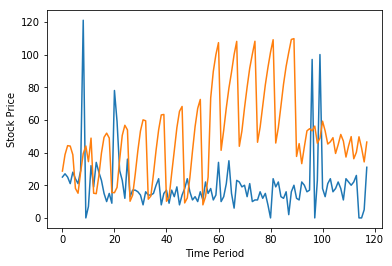

In [31]:
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalSales)
    rmse_val = sess.run(rmse, feed_dict={targets: denormalizedTestY_feed, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(denormalizedTestY_feed)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [32]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [33]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

45.533100047884275